In [62]:
import pandas as pd
import numpy as np
import hts
from hts.hierarchy import HierarchyTree

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)

In [2]:
import sys
sys.path.append('/Users/Boris/Desktop/hp_code_challenge/')
from hp import *

In [36]:
df = pd.read_csv('data/train.csv')

## First look at the data

In [4]:
# No null
# 10 stores
# 50 items
# 500 separate time series
# 1826 days = 5 years
# 1826*50*10 = 913'000 rows

In [5]:
1826/365

5.002739726027397

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [7]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [8]:
#df['store'] = df['store'].apply(lambda x: f's{x}')
#df['item'] = df['item'].apply(lambda x: f'i{x}')

In [37]:
df['store_item'] = df.apply(lambda x: f"{x['store']}_{x['item']}", axis=1)

In [38]:
# 50*10 = 500 store_item combination as expected
# For each store, there is a sales number for each item
len(df['store_item'].unique())

500

In [39]:
## There are 10 stores
len(df['date'].value_counts())

1826

In [40]:
df['item'].value_counts().head()
df['item'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [41]:
# bottom level
df_bottom_level = df.pivot(index='date', columns='store_item', values='sales')
df_bottom_level.head()

store_item,10_1,10_10,10_11,10_12,10_13,10_14,10_15,10_16,10_17,10_18,...,9_46,9_47,9_48,9_49,9_5,9_50,9_6,9_7,9_8,9_9
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,14,45,49,41,46,30,51,20,20,45,...,34,6,28,11,9,36,29,30,45,27
2013-01-02,14,50,47,36,57,48,59,18,17,48,...,28,14,38,16,11,44,33,24,43,36
2013-01-03,16,53,60,39,36,45,49,10,25,50,...,41,18,24,20,8,29,19,35,34,25
2013-01-04,17,51,47,52,54,30,55,14,16,54,...,41,15,30,19,15,43,33,35,41,31
2013-01-05,12,54,31,49,55,45,72,14,16,67,...,42,13,33,16,13,53,36,28,49,30


In [42]:
# middle level
df_middle_level = df.groupby(['date', 'store']) \
                    .sum() \
                    .reset_index() \
                    .pivot(index='date', columns='store', values='sales')

In [43]:
df_middle_level.head()

store,1,2,3,4,5,6,7,8,9,10
date,,,,,,,,,,
2013-01-01,1316,1742,1588,1423,1032,1099,964,1628,1383,1521
2013-01-02,1264,1808,1538,1432,997,1023,944,1687,1455,1530
2013-01-03,1305,1887,1635,1534,1130,1149,966,1736,1492,1654
2013-01-04,1452,1983,1741,1685,1258,1201,1040,1966,1612,1739
2013-01-05,1499,2087,1887,1649,1154,1286,1131,2005,1698,1841


In [44]:
df_total = df.groupby('date')['sales'] \
                .sum() \
                .to_frame() \
                .rename(columns={"sales": "total"})
df_total.head()

,total
date,
2013-01-01,13696
2013-01-02,13678
2013-01-03,14488
2013-01-04,15677
2013-01-05,16237


In [45]:
h_df = df_bottom_level.join(df_middle_level).join(df_total)
h_df.index = pd.to_datetime(h_df.index)

In [46]:
h_df.head(1)

,10_1,10_10,10_11,10_12,10_13,10_14,10_15,10_16,10_17,10_18,...,2,3,4,5,6,7,8,9,10,total
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,14,45,49,41,46,30,51,20,20,45,...,1742,1588,1423,1032,1099,964,1628,1383,1521,13696


In [47]:
print(f"Number of time series at the bottom level: {df_bottom_level.shape[1]}")
print(f"Number of time series at the middle level: {df_middle_level.shape[1]}")
print(f"Number of time series at the top level   : {df_total.shape[1]}")

Number of time series at the bottom level: 500
Number of time series at the middle level: 10
Number of time series at the top level   : 1


## Creating the hierarchy

In [48]:
stores = df['store'].unique()
items = df['store_item'].unique()

In [49]:
total = {'total':list(stores)}

In [50]:
store = {k: [i for i in items if i.startswith(str(k)+'_')] for k in stores}

In [59]:
hierarchy = {**total, **store}

In [66]:
#HierarchyTree.from_nodes(hierarchy, h_df, root='total')

In [70]:
#hierarchy

## Visualization of data

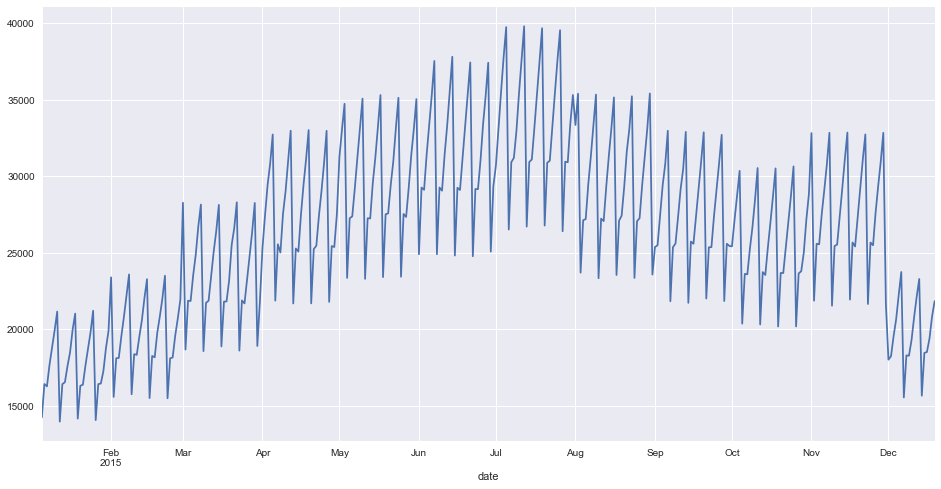

In [88]:
h_df['2015-01-05':'2015-12-19']['total'].plot()

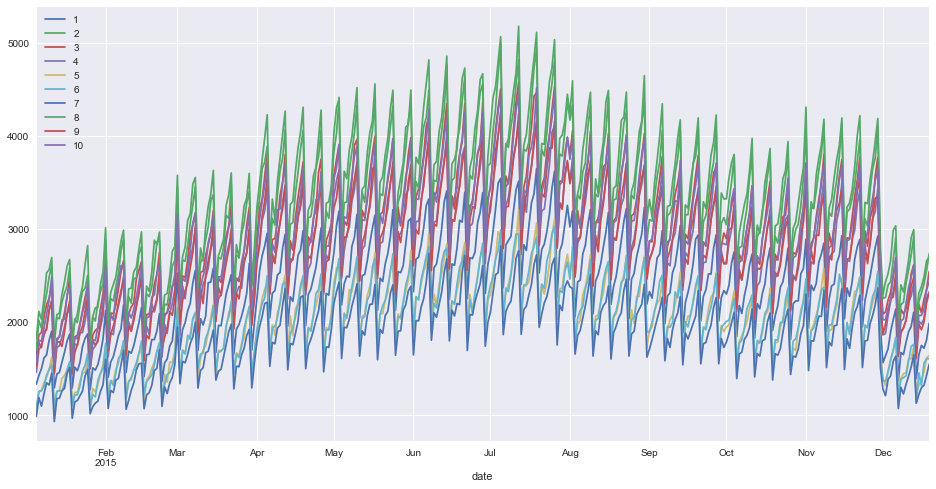

In [89]:
h_df['2015-01-05':'2015-12-19'][hierarchy['total']].plot()

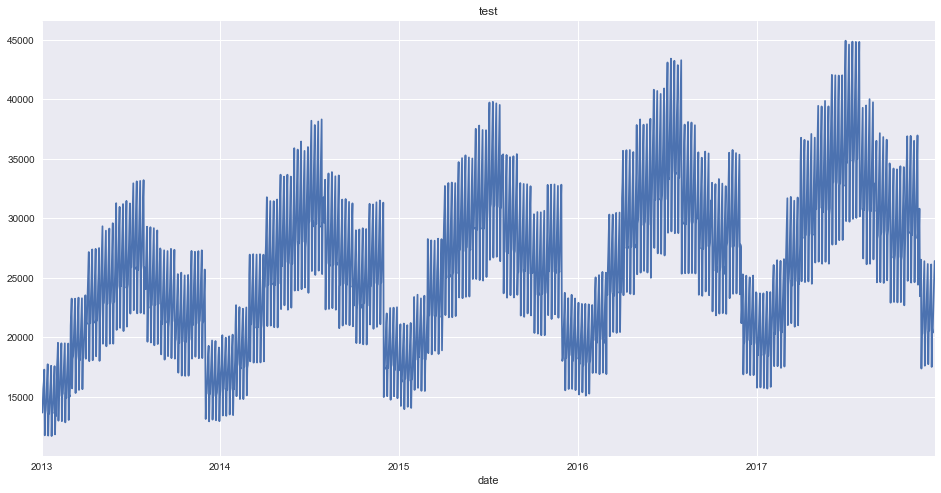

In [76]:
h_df['total'].plot(title='test')

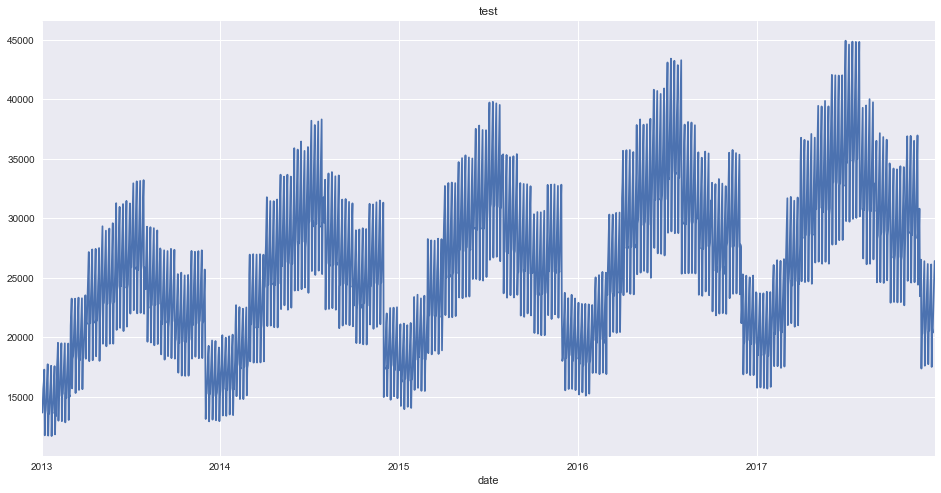

In [77]:
h_df['total'].plot(title='test')